In [10]:
import json
import math
import random

import numpy as np
import pandas
import requests
import networkx as nx
import plotly.graph_objects as go
from gseapy import enrichr

from indra.statements import stmts_from_json
from indra.databases import uniprot_client, hgnc_client
from indra.assemblers.html import HtmlAssembler
from indra.assemblers.cx.assembler import CxAssembler
from indra.assemblers.cx.assembler import NiceCxAssembler
from indra.assemblers.english.assembler import EnglishAssembler
from indra.assemblers.sif.assembler import SifAssembler
from indra.assemblers.graph.assembler import GraphAssembler

In [11]:
DATASET_PATH = "model.csv" # Set this path yourself

## MODULE 1: GILDA

In [12]:
# UI: https://grounding.indra.bio
public_url = 'http://grounding.indra.bio/ground'
def ground(url, text, context=None):
    res = requests.post(url, json={'text': text, 'context': context})
    return res.json()

In [13]:
# MEK1 grounding
grounding = ground(public_url, 'MEK1')
grounding

[{'match': {'cap_combos': [],
   'dash_mismatches': [],
   'exact': True,
   'query': 'MEK1',
   'ref': 'MEK1',
   'space_mismatch': False},
  'score': 1.0,
  'term': {'db': 'HGNC',
   'entry_name': 'MAP2K1',
   'id': '6840',
   'norm_text': 'mek1',
   'organism': '9606',
   'source': 'famplex',
   'status': 'curated',
   'text': 'MEK1'},
  'url': 'https://identifiers.org/hgnc:6840'}]

In [14]:
# MEK2 grounding
grounding = ground(public_url, 'MEK2')
grounding

[{'match': {'cap_combos': [],
   'dash_mismatches': [],
   'exact': True,
   'query': 'MEK2',
   'ref': 'MEK2',
   'space_mismatch': False},
  'score': 0.5555555555555556,
  'term': {'db': 'HGNC',
   'entry_name': 'MAP2K2',
   'id': '6842',
   'norm_text': 'mek2',
   'organism': '9606',
   'source': 'uniprot',
   'source_db': 'UP',
   'source_id': 'P36507',
   'status': 'synonym',
   'text': 'MEK2'},
  'url': 'https://identifiers.org/hgnc:6842'}]

In [15]:
# MEK family grounding
grounding = ground(public_url, 'MEK')
grounding

[{'match': {'cap_combos': [],
   'dash_mismatches': [],
   'exact': True,
   'query': 'MEK',
   'ref': 'MEK',
   'space_mismatch': False},
  'score': 1.0,
  'term': {'db': 'FPLX',
   'entry_name': 'MEK',
   'id': 'MEK',
   'norm_text': 'mek',
   'source': 'famplex',
   'status': 'curated',
   'text': 'MEK'},
  'url': 'https://identifiers.org/fplx:MEK'},
 {'match': {'cap_combos': [],
   'dash_mismatches': [],
   'exact': True,
   'query': 'MEK',
   'ref': 'MEK',
   'space_mismatch': False},
  'score': 0.5555555555555556,
  'term': {'db': 'CHEBI',
   'entry_name': 'butan-2-one',
   'id': 'CHEBI:28398',
   'norm_text': 'mek',
   'source': 'chebi',
   'status': 'synonym',
   'text': 'MEK'},
  'url': 'https://identifiers.org/CHEBI:28398'}]

In [16]:
# NFkappaB complex grounding
grounding = ground(public_url, 'NF- κB')
grounding

[{'match': {'cap_combos': [],
   'dash_mismatches': [],
   'exact': False,
   'query': 'NF- κB',
   'ref': 'NF kappaB',
   'space_mismatch': True},
  'score': 0.5400948258091115,
  'term': {'db': 'FPLX',
   'entry_name': 'NFkappaB',
   'id': 'NFkappaB',
   'norm_text': 'nf kappab',
   'source': 'mesh',
   'source_db': 'MESH',
   'source_id': 'D016328',
   'status': 'synonym',
   'text': 'NF kappaB'},
  'url': 'https://identifiers.org/fplx:NFkappaB'}]

In [17]:
ground(public_url, 'IR', context='IR binds INS at the membrane.')[0]

{'disambiguation': {'match': 'grounded',
  'score': 0.9945447300565196,
  'type': 'adeft'},
 'match': {'cap_combos': [],
  'dash_mismatches': [],
  'exact': True,
  'query': 'IR',
  'ref': 'IR',
  'space_mismatch': False},
 'score': 0.9945447300565196,
 'term': {'db': 'HGNC',
  'entry_name': 'INSR',
  'id': '6091',
  'norm_text': 'ir',
  'organism': '9606',
  'source': 'famplex',
  'status': 'curated',
  'text': 'IR'},
 'url': 'https://identifiers.org/hgnc:6091'}

In [18]:
ground(public_url, 'IR', context='IR can cause DNA damage.')[0]

{'disambiguation': {'match': 'grounded',
  'score': 0.9915279740334499,
  'type': 'adeft'},
 'match': {'cap_combos': [],
  'dash_mismatches': [],
  'exact': True,
  'query': 'IR',
  'ref': 'IR',
  'space_mismatch': False},
 'score': 0.9915279740334499,
 'term': {'db': 'MESH',
  'entry_name': 'Radiation, Ionizing',
  'id': 'D011839',
  'norm_text': 'ir',
  'source': 'famplex',
  'source_db': 'MESH',
  'source_id': 'D011839',
  'status': 'curated',
  'text': 'IR'},
 'url': 'https://identifiers.org/mesh:D011839'}

In [19]:
names_url = 'http://grounding.indra.bio/names'
def get_names(url, db, id, source = None):
    res = requests.post(url, json={'db': db, 'id': id, 'source': source})
    return res.json()

In [20]:
# MEK1 names
names = get_names(names_url, 'HGNC', '6840')
names

['Dual specificity mitogen-activated protein kinase kinase 1',
 'ERK activator kinase 1',
 'MAP Kinase Kinase 1',
 'MAP kinase kinase 1',
 'MAP2K1',
 'MAP2K1 Protein',
 'MAPK Kinase 1',
 'MAPK/ERK kinase 1',
 'MAPKK 1',
 'MAPKK1',
 'MEK 1',
 'MEK 1 Protein Kinase',
 'MEK-1 Protein Kinase',
 'MEK1',
 'MEK1 Protein Kinase',
 'MKK 1 Protein Kinase',
 'MKK-1 Protein Kinase',
 'MKK1',
 'MKK1 Protein Kinase',
 'Mitogen Activated Protein Kinase Kinase 1',
 'Mitogen-Activated Protein Kinase Kinase 1',
 'PRKMK1',
 'mitogen-activated protein kinase kinase 1']

In [21]:
# MEK2 names
names = get_names(names_url, 'HGNC', '13575')
names

['BRD4',
 'Bromodomain-containing protein 4',
 'CAP',
 'HUNK1',
 'HUNKI',
 'MCAP',
 'Protein HUNK1',
 'bromodomain containing 4',
 'chromosome-associated protein',
 'mitotic chromosome-associated protein']

### Famplex

In [22]:
# Famplex
names = get_names(names_url, 'HGNC', '6840', 'famplex')
names

['MAP2K1', 'MEK1']

In [23]:
# MEK2 famplex
names = get_names(names_url, 'HGNC', '6842', 'famplex')
names

['MAP2K2']

In [24]:
# MEK families
names = get_names(names_url, 'FPLX', 'MEK')
names

['MEK', 'MEK 1/2', 'MEK1/2']

In [25]:
from famplex import in_famplex
print(in_famplex('HGNC', 'BRD2'))
print(in_famplex('HGNC', 'MAPK1'))

False
True


In [26]:
from famplex import parent_terms
print(parent_terms('HGNC', 'MAPK1'))
print(parent_terms('HGNC', 'MAPK3'))

[('FPLX', 'ERK')]
[('FPLX', 'ERK')]


In [27]:
from famplex import child_terms
child_terms('FPLX', 'ERK')

[('HGNC', 'MAPK1'), ('HGNC', 'MAPK3')]

In [28]:
from famplex import descendant_terms
descendant_terms('FPLX', 'Histone')

[('FPLX', 'Histone_H1'),
 ('FPLX', 'Histone_H2A'),
 ('FPLX', 'Histone_H2B'),
 ('FPLX', 'Histone_H3'),
 ('FPLX', 'Histone_H4'),
 ('HGNC', 'H1-0'),
 ('HGNC', 'H1-1'),
 ('HGNC', 'H1-10'),
 ('HGNC', 'H1-2'),
 ('HGNC', 'H1-3'),
 ('HGNC', 'H1-4'),
 ('HGNC', 'H1-5'),
 ('HGNC', 'H1-6'),
 ('HGNC', 'H1-7'),
 ('HGNC', 'H1-8'),
 ('HGNC', 'H2AB1'),
 ('HGNC', 'H2AC1'),
 ('HGNC', 'H2AC12'),
 ('HGNC', 'H2AC14'),
 ('HGNC', 'H2AC20'),
 ('HGNC', 'H2AC21'),
 ('HGNC', 'H2AC25'),
 ('HGNC', 'H2AC6'),
 ('HGNC', 'H2AC7'),
 ('HGNC', 'H2AJ'),
 ('HGNC', 'H2AX'),
 ('HGNC', 'H2AZ1'),
 ('HGNC', 'H2AZ2'),
 ('HGNC', 'MACROH2A1'),
 ('HGNC', 'MACROH2A2'),
 ('UP', 'P04908'),
 ('UP', 'P0C0S8'),
 ('UP', 'P0C5Y9'),
 ('UP', 'Q6FI13'),
 ('HGNC', 'H2BC1'),
 ('HGNC', 'H2BC11'),
 ('HGNC', 'H2BC12'),
 ('HGNC', 'H2BC12L'),
 ('HGNC', 'H2BC13'),
 ('HGNC', 'H2BC14'),
 ('HGNC', 'H2BC15'),
 ('HGNC', 'H2BC17'),
 ('HGNC', 'H2BC18'),
 ('HGNC', 'H2BC19P'),
 ('HGNC', 'H2BC20P'),
 ('HGNC', 'H2BC21'),
 ('HGNC', 'H2BC26'),
 ('HGNC', 'H2BC3'),


In [29]:
from famplex import ancestral_terms
ancestral_terms('HGNC', 'H1-0')

[('FPLX', 'Histone_H1'), ('FPLX', 'Histone')]

## MODULE 4: INDRA

In [30]:
# Small molecules targeting BRD2, BRD3, BRD4
from indra.sources.indra_db_rest.api import get_statements_from_query
from indra.sources.indra_db_rest.query import HasAgent, HasType, HasEvidenceBound
query = ((HasAgent("BRD2") | HasAgent("BRD3") | HasAgent("BRD4")) & HasEvidenceBound([">= 25"]))
p = get_statements_from_query(query, sort_by = "belief")
p.statements[0]

INFO: [2024-04-18 13:50:24] indra_db_rest.query_processor - Retrieving statements that (have an agent where NAME=BRD2, have an agent where NAME=BRD3, or have an agent where NAME=BRD4) and have >= 25 evidence.
INFO: [2024-04-18 13:50:24] indra_db_rest.request_logs - Running 0th request for statements
INFO: [2024-04-18 13:50:24] indra_db_rest.request_logs -   LIMIT: None
INFO: [2024-04-18 13:50:24] indra_db_rest.request_logs -   OFFSET: 0


Phosphorylation(None, BRD4())

In [31]:
print(p.get_ev_count(p.statements[0]))
print(p.get_belief_score_by_stmt(p.statements[0]))
print(p.get_source_count(p.statements[0]))

312
0.99999994
{'hprd': 0, 'bel_lc': 0, 'ctd': 0, 'rlimsp': 17, 'signor': 0, 'conib': 0, 'cbn': 0, 'ubibrowser': 0, 'psp': 0, 'vhn': 0, 'biogrid': 0, 'reach': 0, 'tas': 0, 'pe': 0, 'dgi': 0, 'sparser': 294, 'trrust': 0, 'pc': 0, 'trips': 1, 'crog': 0, 'eidos': 0, 'isi': 0, 'drugbank': 0}


In [32]:
p.statements

[Phosphorylation(None, BRD4()),
 Complex(BRD4(), CCNT1()),
 Complex(BRD4(), CDK9()),
 Complex(BRD4(), JMJD6()),
 Inhibition(JQ1(), BRD4()),
 Acetylation(None, BRD4()),
 Complex(BRD4(), EP300()),
 Complex(NSD3(), BRD4()),
 Inhibition(JQ1(), BRD4()),
 Complex(BRD3(), BRD4()),
 Inhibition(7-(3,5-dimethyl-4-isoxazolyl)-8-methoxy-1-[(1R)-1-(2-pyridinyl)ethyl]-3H-imidazo[4,5-c]quinolin-2-one(), BRD4()),
 Inhibition(BRD4(), BRD2()),
 Activation(JQ1(), apoptotic process()),
 Complex(BRD2(), BRD3()),
 Complex(BRD2(), BRD4()),
 Complex(Histone(), BRD4()),
 Activation(BRD4(), transcription, DNA-templated()),
 Complex(BRD4(), RELA()),
 Complex(BRD4(), PIN1()),
 Complex(TP53(), BRD4()),
 Complex(BRD4(), MYC()),
 Complex(NFkappaB(), BRD4()),
 Acetylation(BRD4(), Histone()),
 Complex(BRD4(), ETS1()),
 Complex(Histone_H4(), BRD4()),
 Inhibition(BRD4(), cell population proliferation()),
 Activation(BRD4(), MYC()),
 Ubiquitination(None, BRD4()),
 Activation(BRD4(), inflammatory response()),
 Complex(BRD

In [33]:
ha = HtmlAssembler(p.statements,
                   title='INDRA subnetwork statements',
                   db_rest_url='https://db.indra.bio',
                   ev_counts=p.get_ev_counts(),
                   source_counts=p.get_source_counts())
html_str = ha.make_model()

INFO: [2024-04-18 13:50:35] indra.assemblers.html.assembler - Removing CHEBI from refs due to too many matches: {'CHEBI:137113', 'CHEBI:95080'}


In [60]:
from IPython.core.display import HTML
# HTML(html_str)

In [ ]:
# Query for https://db.indra.bio/statements/from_agents?subject=dBET6&format=html
from indra.sources.indra_db_rest.api import get_statements_from_query
from indra.sources.indra_db_rest.query import HasAgent, HasType, HasEvidenceBound
query = HasAgent("dBET6")
p = get_statements_from_query(query, sort_by = "belief")

ha = HtmlAssembler(p.statements,
                   title='INDRA subnetwork statements',
                   db_rest_url='https://db.indra.bio',
                   ev_counts=p.get_ev_counts(),
                   source_counts=p.get_source_counts())
html_str = ha.make_model()
# HTML(html_str)

INFO: [2024-04-18 13:51:46] indra_db_rest.query_processor - Retrieving statements that have an agent where NAME=dBET6.
INFO: [2024-04-18 13:51:46] indra_db_rest.request_logs - Running 0th request for statements
INFO: [2024-04-18 13:51:46] indra_db_rest.request_logs -   LIMIT: None
INFO: [2024-04-18 13:51:46] indra_db_rest.request_logs -   OFFSET: 0


## MODULE 5: NETWORK SEARCH

In [36]:
# https://network.indra.bio/#/
url = 'https://network.indra.bio/api/query'
res = requests.post(url, json={'source': 'BRD2'})
res.json()['path_results']['paths']['2'][0]

{'path': [{'name': 'BRD2',
   'namespace': 'HGNC',
   'identifier': '1103',
   'lookup': 'https://identifiers.org/hgnc:1103',
   'sign': None},
  {'name': 'BRD4',
   'namespace': 'HGNC',
   'identifier': '13575',
   'lookup': 'https://identifiers.org/hgnc:13575',
   'sign': None}],
 'edge_data': [{'edge': [{'name': 'BRD2',
     'namespace': 'HGNC',
     'identifier': '1103',
     'lookup': 'https://identifiers.org/hgnc:1103',
     'sign': None},
    {'name': 'BRD4',
     'namespace': 'HGNC',
     'identifier': '13575',
     'lookup': 'https://identifiers.org/hgnc:13575',
     'sign': None}],
   'statements': {'Complex': {'stmt_type': 'Complex',
     'source_counts': {'sparser': 132, 'reach': 39, 'biogrid': 1},
     'statements': [{'stmt_type': 'Complex',
       'evidence_count': 1,
       'stmt_hash': 11142804140113966,
       'source_counts': {'sparser': 1},
       'belief': 0.65,
       'curated': False,
       'english': 'BRD2 binds BRD4.',
       'weight': 0.4307829160924542,
     

## MODULE 7: INDRA COGEX

In [37]:
def uniprot_to_hgnc(uniprot_mnemonic):
    """Get an HGNC ID from a UniProt mnemonic."""
    uniprot_id = uniprot_client.get_id_from_mnemonic(uniprot_mnemonic)
    if uniprot_id:
        return uniprot_client.get_hgnc_id(uniprot_id)
    else:
        return None

uniprot_to_hgnc("BRD2_HUMAN")

'1103'

In [38]:
# Filter dataset
LABELS_FILTER = ["DMSO-DbET6"]
P_VALUE_FILTER = 0.05

def construct_df(filename):
    """Return a filtered data frame from the given data file."""
    pandas_df = pandas.read_csv(filename)
    pandas_df = pandas_df[pandas_df['adj.pvalue'] < P_VALUE_FILTER]
    pandas_df = pandas_df[pandas_df['issue'].isnull()]
    pandas_df = pandas_df[pandas_df['Label'].isin(LABELS_FILTER)]
    pandas_df['HGNC'] = pandas_df['Protein'].apply(
        lambda uniprot_mnemonic: uniprot_to_hgnc(uniprot_mnemonic)
    )
    pandas_df = pandas_df[pandas_df['HGNC'].notnull()]
    return pandas_df

In [39]:
def get_protein_groundings(df):
    """Return all HGNC IDs derived from the data frame."""
    groundings = set()
    for index, row in df.iterrows():
        groundings.add(('HGNC', row['HGNC']))
    return sorted(groundings)

In [40]:
def query_indra_subnetwork(groundings):
    """Return a list INDRA subnetwork relations based on a list of groundings."""
    res = requests.post(
        'https://discovery.indra.bio/api/indra_subnetwork_relations',
        json={'nodes': groundings}
    )
    return res.json()

In [41]:
pandas_df = construct_df(DATASET_PATH)
groundings = get_protein_groundings(pandas_df)
subnetwork_relations = query_indra_subnetwork(groundings)

In [42]:
subnetwork_relations[1]

{'data': {'belief': 0.86,
  'evidence_count': 2,
  'has_database_evidence': False,
  'has_reader_evidence': True,
  'has_retracted_evidence': False,
  'medscan_only': False,
  'source_counts': '{"sparser": 2}',
  'sparser_only': True,
  'stmt_hash': 2920021794798921,
  'stmt_json': '{"type": "Complex", "members": [{"name": "BRD2", "db_refs": {"UP": "P25440", "TEXT": "Brd2", "HGNC": "1103", "EGID": "6046"}}, {"name": "BRD4", "db_refs": {"UP": "O60885", "TEXT": "Brd4", "HGNC": "13575", "EGID": "23476"}}, {"name": "IL6", "db_refs": {"UP": "P05231", "HGNC": "6018", "EGID": "3569", "TEXT": "IL-6"}}], "belief": 0.86, "evidence": [{"source_api": "sparser", "pmid": "23420887", "text": "Both Brd2 and Brd4 modestly bound the IL-6 promoter in the non-stimulated cells ( xref ); however, when cells were activated with LPS, we observed significant amounts of IL-6 promoter DNA precipitated with anti-Brd2 and anti-Brd4 antibodies ( xref ).", "annotations": {"found_by": "BINDING"}, "text_refs": {"PMID"

In [43]:
# Gather statistics for HTML presentation
unique_stmts = {entry['data']['stmt_hash']: json.loads(entry['data']['stmt_json'])
                for entry in subnetwork_relations}
ev_counts_by_hash = {entry['data']['stmt_hash']: entry['data']['evidence_count']
                     for entry in subnetwork_relations}
source_counts_by_hash = {entry['data']['stmt_hash']: json.loads(entry['data']['source_counts'])
                         for entry in subnetwork_relations}
stmts = stmts_from_json(list(unique_stmts.values()))

In [44]:
ha = HtmlAssembler(stmts,
                   title='INDRA subnetwork statements',
                   db_rest_url='https://db.indra.bio',
                   ev_counts=ev_counts_by_hash,
                   source_counts=source_counts_by_hash)
html_str = ha.make_model()

In [59]:
from IPython.core.display import HTML
# HTML(html_str)

## MODULE 8: PLAY WITH OWN DATA

In [46]:
GROUPS_FILTER = ['DMSO', 'DbET6']
def construct_protein_level_df(filename):
    pandas_df = pandas.read_csv(filename)
    pandas_df = pandas_df[pandas_df['GROUP'].isin(GROUPS_FILTER)]
    pandas_df['HGNC'] = pandas_df['Protein'].apply(
        lambda uniprot_mnemonic: uniprot_to_hgnc(uniprot_mnemonic)
    )
    return pandas_df

protein_df = construct_protein_level_df("ProteinLevelData.csv")
protein_df

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature,HGNC
0,1,1433B_HUMAN,12.873423,230719_THP-1_Chrom_end2end_Plate1_DMSO_A02_DIA,DMSO,2,1210,10,0.0,False,0,12849
1,2,1433B_HUMAN,12.866217,230719_THP-1_Chrom_end2end_Plate1_DMSO_A05_DIA,DMSO,5,1210,10,0.0,False,0,12849
2,3,1433B_HUMAN,12.686827,230719_THP-1_Chrom_end2end_Plate1_DMSO_A10_DIA,DMSO,10,1210,10,0.0,False,0,12849
3,4,1433B_HUMAN,12.625462,230719_THP-1_Chrom_end2end_Plate1_DMSO_A12_DIA,DMSO,12,1210,10,0.0,False,0,12849
4,5,1433B_HUMAN,12.538365,230719_THP-1_Chrom_end2end_Plate1_DMSO_B01_DIA,DMSO,13,1210,10,0.0,False,0,12849
...,...,...,...,...,...,...,...,...,...,...,...,...
1189700,145,ZZZ3_HUMAN,10.725469,230719_THP-1_Chrom_end2end_Plate3_PF477736_D05,DbET6,233,169,10,0.0,False,0,24523
1189701,146,ZZZ3_HUMAN,10.155338,230719_THP-1_Chrom_end2end_Plate3_DMSO_D06,DbET6,234,169,10,0.0,False,0,24523
1189702,147,ZZZ3_HUMAN,9.700678,230719_THP-1_Chrom_end2end_Plate3_K975_D12,DbET6,240,169,10,0.0,False,0,24523
1189703,148,ZZZ3_HUMAN,10.889323,230719_THP-1_Chrom_end2end_Plate3_VTP50469_F06,DbET6,258,169,10,0.0,False,0,24523


In [47]:
def calculate_correlation(hgnc_id_1, hgnc_id_2, protein_level_summary):
    filtered_df = protein_level_summary[protein_level_summary['HGNC'].isin([hgnc_id_1, hgnc_id_2])]
    x = []
    y = []
    for subject in filtered_df['SUBJECT'].unique():
        subject_level_df = filtered_df[filtered_df['SUBJECT'] == subject]
        subject_level_df_x = subject_level_df[subject_level_df['HGNC'] == hgnc_id_1]
        subject_level_df_y = subject_level_df[subject_level_df['HGNC'] == hgnc_id_2]
        if len(subject_level_df_x) > 0 and len(subject_level_df_y) > 0:
            x.append(subject_level_df_x['LogIntensities'].iloc[0])
            y.append(subject_level_df_y['LogIntensities'].iloc[0])
    return np.corrcoef(x, y)

calculate_correlation('1103', '1104', protein_df)[0][1]

0.7977079398612225

In [48]:
from indra.assemblers.indranet.assembler import IndraNetAssembler
def extra_column_function(stmt, ev_counts = ev_counts_by_hash):
    hash = stmt.get_hash(refresh=True)
    return ev_counts[hash]
ina = IndraNetAssembler(statements=stmts)
df = ina.make_df(extra_columns=[('evidence_count', extra_column_function)])
relations_df = df.sort_values(by=['evidence_count'], ascending=False)
relations_df

,agA_name,agB_name,agA_ns,agA_id,agB_ns,agB_id,residue,position,stmt_type,evidence_count,stmt_hash,belief,source_counts,initial_sign
119,BRD4,BRD2,HGNC,13575,HGNC,1103,None,None,Complex,113,12484535149707124,0.999950,{'reach': 1},None
118,BRD2,BRD4,HGNC,1103,HGNC,13575,None,None,Complex,113,12484535149707124,0.999950,{'reach': 1},None
231,BRD4,BRD3,HGNC,13575,HGNC,1104,None,None,Complex,51,359233681958482,0.999975,{'sparser': 1},None
232,BRD3,BRD4,HGNC,1104,HGNC,13575,None,None,Complex,51,359233681958482,0.999975,{'sparser': 1},None
151,BRD2,BRD3,HGNC,1103,HGNC,1104,None,None,Complex,42,-16515703320827288,0.999950,{'sparser': 1},None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,JMJD6,BRD2,HGNC,19355,HGNC,1103,None,None,Complex,1,34194495135899326,0.650000,{'sparser': 1},None
158,JMJD6,BRD3,HGNC,19355,HGNC,1104,None,None,Complex,1,34194495135899326,0.650000,{'sparser': 1},None
159,KRR1,NOP2,HGNC,5176,HGNC,7867,None,None,Complex,1,-24130039704357981,0.980000,{'biogrid': 1},None
160,NOP2,KRR1,HGNC,7867,HGNC,5176,None,None,Complex,1,-24130039704357981,0.980000,{'biogrid': 1},None


In [49]:
LOG_FC_FILTER = 0.25
pandas_df['log2FC'] = pandas_df['log2FC'].astype(float)
correlated_proteins = pandas_df[pandas_df['log2FC'] > LOG_FC_FILTER]
correlated_proteins

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,HGNC
19890,BRD2_HUMAN,DMSO-DbET6,2.046185,0.114339,17.895836,260.0,0.000000e+00,0.000000,NaN,0.310067,0.0,1103
19935,BRD3_HUMAN,DMSO-DbET6,3.333428,0.126571,26.336522,257.0,0.000000e+00,0.000000,NaN,0.252349,0.0,1104
19980,BRD4_HUMAN,DMSO-DbET6,2.668935,0.101283,26.351317,257.0,0.000000e+00,0.000000,NaN,0.118121,0.0,13575
41580,DAZP1_HUMAN,DMSO-DbET6,0.617508,0.099537,6.203818,260.0,2.159950e-09,0.000002,NaN,0.286577,0.0,2683
66060,FUBP2_HUMAN,DMSO-DbET6,0.291045,0.077226,3.768747,260.0,2.030530e-04,0.047824,NaN,0.017450,0.0,6316
66105,FUBP3_HUMAN,DMSO-DbET6,0.300410,0.069882,4.298798,260.0,2.430235e-05,0.008941,NaN,0.095302,0.0,4005
137745,PP1R8_HUMAN,DMSO-DbET6,0.358282,0.069056,5.188314,260.0,4.275951e-07,0.000235,NaN,0.045638,0.0,9296
140535,PRP18_HUMAN,DMSO-DbET6,0.485713,0.120799,4.020834,260.0,7.603588e-05,0.022122,NaN,0.049664,0.0,17351
145440,QKI_HUMAN,DMSO-DbET6,0.336985,0.055130,6.112567,260.0,3.570594e-09,0.000003,NaN,0.000000,0.0,21100
196155,TIA1_HUMAN,DMSO-DbET6,0.476791,0.105361,4.525306,260.0,9.182867e-06,0.004129,NaN,0.058389,0.0,11802


In [50]:
ga = GraphAssembler(stmts=stmts)
ga.make_model()
ga.save_pdf(file_name='graph.pdf', prog='dot')

In [51]:
# ADHOC: Modify graph with latent, non-latent, and non-latent up-regulated
for node in ga.graph.nodes():
    node_properties = {
        'color': '#808080',
        'shape': 'Mrecord',
        'fontsize': 8
    }
    hgnc_id = hgnc_client.get_hgnc_id(node)
    if not (hgnc_id and pandas_df['HGNC'].str.contains(hgnc_id).any()):
        ga.graph.add_node(node,
                          label=node,
                          **node_properties)
    elif hgnc_id and correlated_proteins['HGNC'].str.contains(hgnc_id).any():
        node_properties['color'] = '#00FF00'
        logFC_value = round(pandas_df[pandas_df['HGNC'] == hgnc_id]['log2FC'].iloc[0], 2)
        ga.graph.add_node(node,
                          label=f'{node}: {logFC_value} LogFC',
                          **node_properties)
    else:
        node_properties['color'] = '#FF0000'
        logFC_value = round(pandas_df[pandas_df['HGNC'] == hgnc_id]['log2FC'].iloc[0], 2)
        ga.graph.add_node(node,
                          label=f'{node}: {logFC_value} LogFC',
                          **node_properties)

color = '#ff0000'
color_default = '#000000'
for edge in ga.graph.edges():
    params = {'color': color_default,
              'arrowhead': 'normal',
              'dir': 'forward'}
    hgnc_id_1 = hgnc_client.get_hgnc_id(edge[0])
    hgnc_id_2 = hgnc_client.get_hgnc_id(edge[1])
    if hgnc_id_1 and pandas_df['HGNC'].str.contains(hgnc_id_1).any() and \
        hgnc_id_2 and pandas_df['HGNC'].str.contains(hgnc_id_2).any():
        correlation = round(calculate_correlation(hgnc_id_1, hgnc_id_2, protein_df)[0][1], 2)
        evidence_df = relations_df[relations_df['agA_name'] == edge[0]]
        evidence_df = evidence_df[evidence_df['agB_name'] == edge[1]]
        evidence = evidence_df['evidence_count'].iloc[0]
        if evidence >= 10 and correlation > 0.3:
            params['color'] = '#00ff00'
        else:
            params['color'] = color
        params['label'] = f'Correlation: {correlation}, Evidence: {evidence}'
    ga.graph.add_edge(edge[0], edge[1], **params)

ga.save_pdf(file_name='graph2.pdf', prog='dot')

## PART 8: MORE ASSEMBLERS

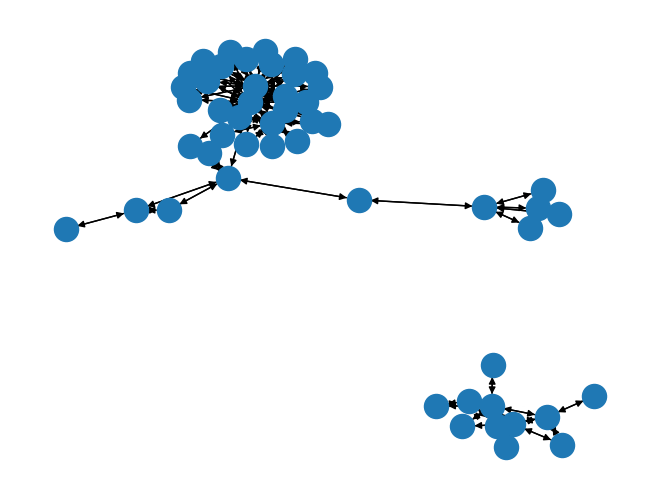

In [52]:
sa = SifAssembler(stmts=stmts)
sa.make_model(use_name_as_key = True, include_mods=True, include_complexes=True)
nx.draw(sa.graph)

In [53]:
# Cytoscape Assembler
ca = CxAssembler(stmts=stmts,
                 network_name="BRD Network")
model = ca.make_model()
ca.save_model(file_name="model.cx")

In [54]:
ea = EnglishAssembler(stmts=stmts)
ea.make_model()

'RAD21 binds BRD2 and BRD4. BRD2 binds BRD4 and IL6. ODC1 binds BRD2 and BRD4. BRD2 binds BRD4 and Histone_H4. Modified BRD4 decreases the amount of BRD2. BRD4 decreases the amount of BRD2. BRD9 binds BRD2 and BRD4. BRD4 binds BRD2 and TYRP1. BRD4 binds BRD2 and MITF. BRDT binds BRD2 and BRD4. LYAR binds BRD2 and BRD4. BRD2 binds MYC and BRD4. BRD4 activates BRD2. BRD4 inhibits BRD2. E binds BRD2 and BRD4. Histone binds BRD2 and BRD4. Bromodomain binds BRD2 and BRD4. BRD2 binds BRD4 and MFSD11. BRD4 binds BRD2 and CTCF. IL17A binds BRD2 and BRD4. DNER binds BRD2 and BRD4. BRD4 binds BRD2 and polB. BRD2 binds BRD3 and BRD4. BRD2 binds BRD4. JMJD6 binds BRD4 and BRD2. BRD2 binds BRD3 and BRDT. BRD2 binds BRD3 and BRD9. Histone binds BRD2 and BRD3. BRD3 inhibits BRD2. BRD7 binds BRD2 and BRD3. BRD2 binds BRD3. BRD2 binds BRD3 and JMJD6. KRR1 binds NOP2. CEBPZ binds NOP2. GTPBP4 binds NOP2. NOP2 binds BRD4 and RNA polymerase activity. NOP2 binds BRD4 and MBTPS2. NOP2 binds BRD4. FUBP1 bind

In [55]:
from indra.assemblers.sbgn.assembler import SBGNAssembler
sa = SBGNAssembler(statements=stmts)
sa.make_model()
sa.save_model(file_name='model.sbgn')

In [56]:
from indra.assemblers.pybel.assembler import PybelAssembler
from pybel_jupyter import to_jupyter
pba = PybelAssembler(stmts=stmts, name="network")
graph = pba.make_model()
print(graph.summarize.statistics())
print(graph.summarize.nodes(examples=False))
print(graph.summarize.namespaces(examples=False))
print(graph.summarize.edges(examples=False))
# to_jupyter(graph)
# pba.save_model("network.bel", output_format="bel")

INFO: [2024-04-18 13:50:59] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent BRD4(mods: (modification))
/Users/tonywu/workspace/IndraDemo/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


---------------------  ------------------------------------
Name                   network
Version                3bd82e86-18bd-4f72-a569-010d4950600d
Number of Nodes        113
Number of Namespaces   4
Number of Edges        177
Number of Annotations  6
Number of Citations    9
Number of Authors      0
Number of Components   2
Number of Warnings     0
Network Density        1.40E-02
---------------------  ------------------------------------
None
Type (3)             Count
-----------------  -------
Complex                 62
Protein                 50
BiologicalProcess        1
None
Namespace (4)      Count
---------------  -------
HGNC                 200
UP                     8
FPLX                   6
GO                     2
None
Edge Type (4)                       Count
--------------------------------  -------
Protein partOf Complex                164
Protein decreases Protein               7
Protein increases Protein               5
BiologicalProcess partOf Complex        1
N

In [57]:
from indra.assemblers.index_card.assembler import IndexCardAssembler
ia = IndexCardAssembler(statements=stmts, pmc_override="PMC")
ia.make_model()
ia.save_model(file_name='index_cards.json')
ia.print_model()

'[\n {\n  "pmc_id": "PMC",\n  "submitter": "indra",\n  "interaction": {\n   "negative_information": false,\n   "hypothesis_information": [\n    null\n   ],\n   "interaction_type": "complexes_with",\n   "participant_a": {\n    "entity_type": "complex",\n    "entity_text": [\n     ""\n    ],\n    "entities": [\n     {\n      "entity_text": [\n       "RAD21"\n      ],\n      "identifier": "UNIPROT:RAD21_HUMAN",\n      "entity_type": "protein"\n     },\n     {\n      "entity_text": [\n       "BRD2"\n      ],\n      "identifier": "UNIPROT:BRD2_HUMAN",\n      "entity_type": "protein"\n     },\n     {\n      "entity_text": [\n       "BRD4"\n      ],\n      "identifier": "UNIPROT:BRD4_HUMAN",\n      "entity_type": "protein"\n     }\n    ]\n   },\n   "context": [\n    null\n   ]\n  },\n  "meta": {\n   "id": "a2b3575a-ae54-4a6a-a256-726aefe5a387",\n   "belief": 0.65\n  },\n  "evidence": [\n   "However, we were unable to demonstrate any direct physical interaction between BRD2 or BRD4 with cohesi

In [58]:
# Errors with tsvAssembler right now:
from indra.assemblers.tsv.assembler import TsvAssembler
ta = TsvAssembler(statements=stmts)
ta.make_model("output.tsv")

INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(RAD21(), BRD2(), BRD4())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(BRD2(), BRD4(), IL6())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(ODC1(), BRD2(), BRD4())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(BRD2(), BRD4(), Histone_H4())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(BRD9(), BRD2(), BRD4())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(BRD4(), BRD2(), TYRP1())
INFO: [2024-04-18 13:51:02] indra.assemblers.tsv.assembler - Skipping statement with more than two members: Complex(BRD4(), BRD2(), MITF())
INFO: [2024-0

IndexError: list index out of range

## PART 9: ADHOC VISUALIZATIONS

In [ ]:
ev_counts = {
    (entry['source_id'], entry['target_id']): entry['data']['evidence_count']
    for entry in subnetwork_relations
}

def initialize_networkx_graph(subnetwork_relations, filter_bidirectional=False):
    """Return a networkx graph from the INDRA relations."""
    G = nx.DiGraph()
    for entry in subnetwork_relations:
        source = entry['source_id']
        target = entry['target_id']
        
        if filter_bidirectional:
            # If there is a statement with opposite direction and more evidence
            # then we skip this one
            if ev_counts[(source, target)] < ev_counts.get((target, source), 0):
                continue

        # Add nodes to graph
        source_name = hgnc_client.get_hgnc_name(source)
        target_name = hgnc_client.get_hgnc_name(target)
        G.add_node(source, label=source_name)
        G.add_node(target, label=target_name)
    
        # Add the edge to the graph
        G.add_edge(
            source,
            target,
            evidence_count=entry['data']['evidence_count'],
            belief=entry['data']['belief'],
            stmt_type=entry['data']['stmt_type']
        )

    return G

In [ ]:
def find_communities(G, weight='evidence_count'):
    """Return the communities of a networkx graph using a custom weight attribute."""
    return nx.community.louvain_communities(G, weight=weight)

In [ ]:
def generate_node_initial_positions(G, communities):
    """Return node positions of a networkx graph based on communities."""
    initial_pos = {}
    circle_r = 1
    big_r = 1
    pi = math.pi
    centers = [(math.cos(2 * pi / len(communities) * x) * big_r, math.sin(2 * pi / len(communities) * x) * big_r)
               for x in range(0, len(communities))]
    for index, nodes in enumerate(communities):
        for node in nodes:
            alpha = 2 * math.pi * random.random()
            r = circle_r * math.sqrt(random.random())
            x = r * math.cos(alpha) + centers[index][0]
            y = r * math.sin(alpha) + centers[index][1]
            initial_pos[node] = [x, y]
            nx.set_node_attributes(G, {node: index}, name='community')
    
    return initial_pos

In [ ]:
def apply_layout_to_graph(G, initial_pos, k=30, iterations=100, weight='evidence_count'):
    """Apply custom layout positions to a networkx graph."""
    pos = nx.spring_layout(G, weight=weight, k=k / math.sqrt(len(G.nodes)), pos=initial_pos, iterations=iterations)
    for node in G.nodes():
        x = pos[node][0]
        y = pos[node][1]
        nx.set_node_attributes(G, {node: [x, y]}, name='pos')
    return G

In [ ]:
def apply_gsea_to_graph(G, communities):
    """Set graph node attributes reflecting top GO enrichment for each node in a community."""
    for index, nodes in enumerate(communities):
        # Do GSEA and fetch top gene set
        gene_list = [hgnc_client.get_hgnc_name(node) for node in nodes]
        gene_sets = enrichr(gene_list=gene_list,
                            gene_sets=['GO_Biological_Process_2023',
                                       'GO_Cellular_Component_2023',
                                       'GO_Molecular_Function_2023'],
                            organism='Human').results
        top_gene_set = (f'{gene_sets["Term"][0]} w/ p-value '
                        f'{str(gene_sets["Adjusted P-value"][0])}')
        for node in nodes:
            nx.set_node_attributes(G, {node: top_gene_set}, name='gsea')

In [ ]:
def construct_networkx_graph(subnetwork_relations):
    """Return a custom networkx graph from INDRA subnetwork relations."""
    G = initialize_networkx_graph(subnetwork_relations)
    communities = find_communities(G)
    initial_pos = generate_node_initial_positions(G, communities)
    apply_layout_to_graph(G, initial_pos)
    apply_gsea_to_graph(G, communities)
    return G


G = construct_networkx_graph(subnetwork_relations)

In [ ]:
G.nodes['13575']

In [ ]:
def construct_arrows(G):
    """Return list of directed edges for network visualization."""
    arrow_list = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']

        arrow = go.layout.Annotation(dict(
            x=x0,
            y=y0,
            xref="x", yref="y",
            showarrow=True,
            axref="x", ayref='y',
            ax=x1,
            ay=y1,
            arrowhead=3,
            arrowwidth=min(5, G.edges[edge]['evidence_count']),
            arrowcolor='lightgreen')
        )

        arrow_list.append(arrow)
    return arrow_list

In [ ]:
def construct_arrow_labels(G):
    """Return custom edge labels for network visualization."""
    mnode_x, mnode_y, mnode_txt = [], [], []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        name0 = G.nodes[edge[0]]['label']
        name1 = G.nodes[edge[1]]['label']

        mnode_x.extend([(x0 + x1) / 2])
        mnode_y.extend([(y0 + y1) / 2])
        mnode_txt.extend([f'{name0}->{name1} evidence count: {G.edges[edge]["evidence_count"]}'])

    mnode_trace = go.Scatter(
        x=mnode_x, y=mnode_y,
        mode="markers",
        showlegend=False,
        hovertext=mnode_txt,
        hovertemplate="Edge %{hovertext}<extra></extra>",
        marker=go.scatter.Marker(opacity=0)
    )
    
    return mnode_trace

In [ ]:
def construct_node_trace(G):
    """Return custom nodes for network visualization"""
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=[data['label'] for node, data in list(G.nodes(data=True))],
        textposition="bottom center",
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=30,
            colorbar=dict(
                thickness=15,
                title='Cluster ID',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_colors = []
    node_text = []
    for node in G.nodes():
        node_text.append(G.nodes[node]['gsea'])
        node_colors.append(G.nodes[node]['community'])

    node_trace.marker.color = node_colors
    node_trace.hovertext = node_text

    return node_trace

In [ ]:
def show_plotly_graph(nodes, arrows):
    """Visualize the network based on the list of nodes and arrows."""
    fig = go.Figure(data=nodes,
                    layout=go.Layout(
                        title='<br>Network graph made with Python',
                        font=dict(
                            family="Courier New, monospace",
                            size=10,
                            color="Black"
                        ),
                        annotations=arrows,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [ ]:
def create_plotly_graph(G):
    """Generate and visualize a custom network from a networkx graph."""
    edges = construct_arrows(G)
    edge_midpoints = construct_arrow_labels(G)
    nodes = construct_node_trace(G)
    show_plotly_graph([edge_midpoints, nodes], edges)

In [ ]:
create_plotly_graph(G)

In [ ]:
G.edges()